In [1]:
import pandas as pd
import numpy as np

# fetch the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# look at datas and targets

X,y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


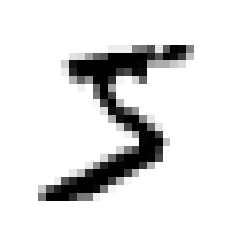

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.loc[0]
some_digit_image = np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

In [6]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [7]:
# training a binary classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [9]:
# use cross_val_value function by yourself
# StratifiedKFold 用于分层抽样

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    # clone 已经训练好的 sgd_clf
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv = 3,scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [11]:
# 将每个照片都分类成not-5的类型
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y = None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv = 3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [13]:
# 构建confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [14]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [15]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [18]:
# how to set your own sgd threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 800
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

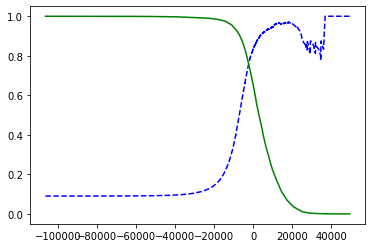

In [20]:
# sgd 获取预测分数 method = "decision function"
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3,
                             method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

# use the plt to plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label = "Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label = "Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

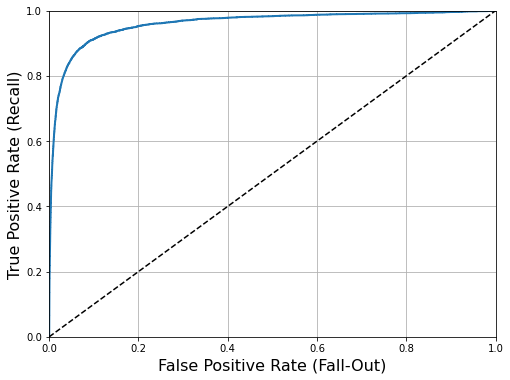

In [21]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.show

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)


0.9604938554008616

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

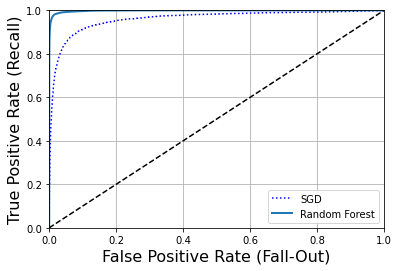

In [24]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,"b:",label = "SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [25]:
roc_auc_score(y_train_5,y_scores_forest)


0.9983436731328145

In [26]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train) # not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [27]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [29]:
# get the max index
np.argmax(some_digit_scores)

5

5

In [30]:
svm_clf.classes_[5]

5

In [31]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

len(ovr_clf.estimators_)

10

In [33]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [34]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [35]:
cross_val_score(sgd_clf,X_train,y_train,cv = 3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [37]:
# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv = 3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

array([0.8983, 0.891 , 0.9018])

In [38]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv = 3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

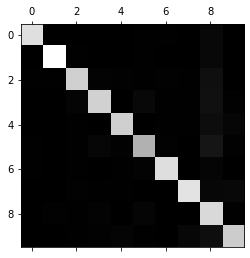

In [39]:
# plot the confuse matrix
plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()

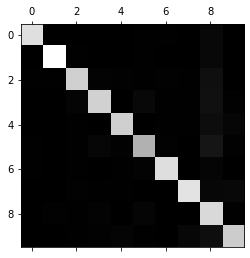

In [40]:
row_sums = conf_mx.sum(axis=1,keepdims = True)
norm_conf_mx = conf_mx / row_sums

# fill the diagonal with 0
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()

In [89]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instances.iloc[index].values.reshape(size,size) for index in range(len(instances))]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

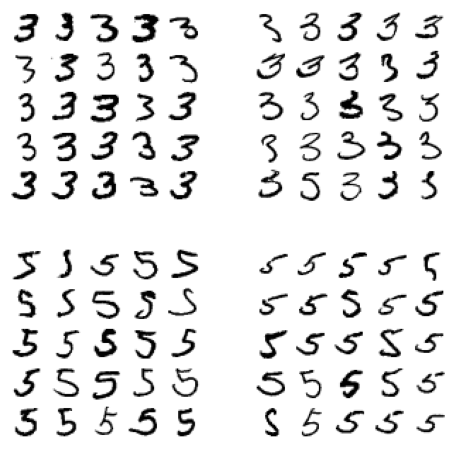

In [91]:
# plot examples of 3s and 5s
cl_a,cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)

In [95]:
# multilabel classification

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_mutilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_mutilabel)

KNeighborsClassifier()

In [96]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [97]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_mutilabel,cv = 3)
f1_score(y_mutilabel,y_train_knn_pred,average="macro")


0.976410265560605

In [102]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [114]:
def plot_digit(data):
    if isinstance(data,pd.Series):
        image = data.values.reshape(28, 28)
    if isinstance(data,np.ndarray):
        image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

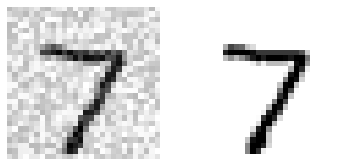

In [115]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index])
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index])
plt.show()

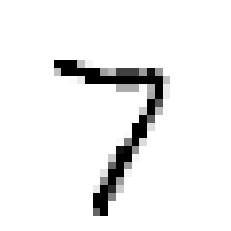

In [116]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit(clean_digit)


